In [25]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lzma as xz
import os

pd.options.display.max_rows = 100
%matplotlib inline

# Biopython Entrez
Provides code to access NCBI over the WWW.  

[Package info](https://biopython.org/DIST/docs/api/Bio.Entrez-module.html)

* `api_key` Personal API key from NCBI. If not set, only 3 queries per second are allowed. 10 queries per seconds otherwise with a valid API key.

### 1. Basics

In [2]:
from Bio import Entrez

In [3]:
from Bio import SeqIO

In [4]:
handle = Entrez.efetch(db="nucleotide", id="NC_045512",
                       rettype="gb", retmode="text")
handle.readline().strip()

'LOCUS       NC_045512              29903 bp ss-RNA     linear   VRL 18-JUL-2020'

### 2. Search via `esearch`

In [6]:
handle = Entrez.esearch(db="nucleotide", retmax=10, term="SARS-CoV-2", idtype="acc")
record = Entrez.read(handle)
handle.close()
print(record)

{'Count': '12266', 'RetMax': '10', 'RetStart': '0', 'IdList': ['NC_045512.2', 'NM_021804.3', 'NM_001371415.1', 'MT773134.1', 'MT773133.1', 'MT772580.1', 'MT772579.1', 'MT772578.1', 'MT772577.1', 'MT772576.1'], 'TranslationSet': [{'From': 'SARS-CoV-2', 'To': '"Severe acute respiratory syndrome coronavirus 2"[Organism] OR SARS-CoV-2[All Fields]'}], 'TranslationStack': [{'Term': '"Severe acute respiratory syndrome coronavirus 2"[Organism]', 'Field': 'Organism', 'Count': '11145', 'Explode': 'Y'}, {'Term': 'SARS-CoV-2[All Fields]', 'Field': 'All Fields', 'Count': '12266', 'Explode': 'N'}, 'OR', 'GROUP'], 'QueryTranslation': '"Severe acute respiratory syndrome coronavirus 2"[Organism] OR SARS-CoV-2[All Fields]'}


### 3. Method From `coronaversing`
To fetch the latest data from NCBI using keywords and a genome size range.

In [67]:
# data folders
root_folder = "./data/genbank/"
viruses = ["coronaviridae"]

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 
cache_regions_file = ".cache_regions.pkl" 

hidden_columns = ["sequence", "file_path", "strain", "collection_date"]
hidden_cds_columns = ["translation", "file_path", "location"]
hidden_regions_columns = ["id", "rna", "protein", "path"]

base_folder = "../data/genbank/"
# Entrez.email = 'dna-toolbox@gmail.com'

size_and_date = "(\"25000\"[SLEN] : \"35000\"[SLEN])"
genbank_search_query = {"coronaviridae": ["(\"Coronaviridae\"[Organism]) AND " + size_and_date]}

def fetch_gb(path, gid):
    handle = Entrez.efetch(db="nucleotide", id=gid, rettype="gb")
    local_file = open(path + "/" + gid + ".gb", 'w')
    local_file.write(handle.read())
    handle.close()
    local_file.close()

genome_files = genbank_search_query
viruses = genbank_search_query.keys()

In [ ]:
retmax = 15000

count = 0
for vrs in viruses:
    
    data_folder = base_folder + vrs
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    for keywords in genome_files[vrs]:
        handle = Entrez.esearch(db="nucleotide", retmax=retmax, term=keywords, idtype="acc")
        record = Entrez.read(handle)
        ids = record["IdList"]
        print("[+] got", len(ids), "records")
        handle.close()

        for genbank_id in ids:
            file_name = data_folder + "/" + genbank_id + ".gb"
            count += 1
            if not os.path.exists(file_name):
                print("\r", count, " [+]  --- * fetching (", vrs, ")", file_name, end="")
                downloaded = False
                tries = 0
                while not downloaded:
                    try:
                        fetch_gb(data_folder, genbank_id)
                        downloaded = True
                    except:
                        if tries == 5:
                            print("[+]  --- * couldn't get (", vrs, ")", genbank_id)
                            break
                        tries += 1
                        time.sleep(3)
                        pass

print("[+] Collected", count, " gb files")

[+] got 14203 records
 32  [+]  --- * fetching ( coronaviridae ) ../data/genbank/coronaviridae/MT782358.1.gb

In [29]:
from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image

# data folders
root_folder = "../data/genbank/"
viruses = ["coronaviridae"]

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 
cache_regions_file = ".cache_regions.pkl" 

hidden_columns = ["sequence", "file_path", "strain", "collection_date"]
hidden_cds_columns = ["translation", "file_path", "location"]
hidden_regions_columns = ["id", "rna", "protein", "path"]

# GISAID data (not includided in the repo, you should add your own fasta file downloaded from the GISAID page)
gisaid_search_query = {"coronaviridae": ["./data/gisaid/"]}
gisaid_tokens_no_wa = 5
gisaid_tokens_no_host = 6
gisaid_tokens_with_host = 7

GENUS = ["deltacoronavirus", "gammacoronavirus", "alphacoronavirus", "betacoronavirus"]

def get_genomes():
    for vrs in viruses:    
        # define data frame structure for viruses
        feature_columns = ["country", "host", "strain", "collection_date"]
        sample_columns = ["id", "length", "date", "information", "description", 
                          "sequence", "file_path", "genus", "subgenus", "unknown"]
        total_columns = sample_columns + feature_columns
        vrs_frame = {i:list() for i in total_columns}

        # define data frame structure for CDS
        cds_feature_columns = ["protein_id", "product", "gene", "codon_start", "translation"]
        cds_sample_columns = ["oid", "type", "date", "file_path", "location", "start", 
                              "end", "length", "unknown"]
        cds_columns = cds_feature_columns + cds_sample_columns
        cds_frame = {i:list() for i in cds_columns}

        # loop over gb files
        data_folder = root_folder + vrs + "/"
        for filename in os.listdir(data_folder):
            if filename.endswith(".gb"): 
                for seq_record in SeqIO.parse(data_folder + filename, "genbank"):

                    # get genome sequence, under certain tolerance to unknown nucleotides
                    genome_sequence = seq_record.seq.upper()
                    
                    if not (seq_record.annotations['molecule_type'] == "RNA" or 
                            seq_record.annotations['molecule_type'] == "ss-RNA"):
                        continue 
                    
                    # get taxonomy
                    genus = "unknown"
                    subgenus = "unknown"
                    if "taxonomy" in seq_record.annotations:
                        taxonomy = seq_record.annotations["taxonomy"]
                        for i in range(0, len(taxonomy)):
                            if taxonomy[i].lower() in GENUS:
                                genus = taxonomy[i].lower()
                                if i + 1 < len(taxonomy):
                                    subgenus = taxonomy[i + 1].lower()
                                    if "unclassified" in subgenus:
                                        subgenus = "unknown"
                                    break
                        
                    # get several additional variables from genbank file featues (if available)
                    for ftrs in seq_record.features:
                        
                        # some metada of the sample
                        if ftrs.type == "source":                        
                            for var in feature_columns:                        
                                if var in ftrs.qualifiers:
                                    # sanitize country
                                    if var == "country":
                                        country = ftrs.qualifiers[var][0]
                                        country = country.split(":")[0]
                                        vrs_frame["country"].append(country.lower())
                                    # sanitize host
                                    elif var == "host":
                                        host = ftrs.qualifiers[var][0]
                                        host = host.split(";")[0]
                                        vrs_frame["host"].append(host.lower())
                                    else:
                                        vrs_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    vrs_frame[var].append("unknown")

                        # collect cds data in a different dataframe
                        if "protein_id" in ftrs.qualifiers:                        
                            for var in cds_feature_columns:                        
                                if var in ftrs.qualifiers:
                                    if var == "gene":
                                        cds_frame[var].append(ftrs.qualifiers[var][0].upper())
                                    elif var == "product":
                                        cds_frame[var].append(ftrs.qualifiers[var][0].lower())
                                    else:
                                        cds_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    cds_frame[var].append("unknown")

                            cds_frame["start"].append(ftrs.location.start)
                            cds_frame["end"].append(ftrs.location.end)
                            cds_frame["length"].append(len(ftrs.location))
                            cds_frame["location"].append(ftrs.location)
                            cds_frame["date"].append(seq_record.annotations["date"])

                            # cds data of the record
                            cds_frame["oid"].append(seq_record.id)
                            cds_frame["file_path"].append(data_folder + filename)
                            cds_frame["type"].append(ftrs.type)
                            
                            translation = cds_frame["translation"][-1]
                            unknown_fraction = float(translation.count("X")) / float(len(translation))
                            cds_frame["unknown"].append(unknown_fraction)

                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(genome_sequence).encode('utf-8')))

                    # genome length
                    genome_length = len(genome_sequence)

                    # sample (virus) data
                    vrs_frame["id"].append(seq_record.id)
                    vrs_frame["date"].append(pd.to_datetime(seq_record.annotations["date"]))
                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(seq_record.description)
                    
                    vrs_frame["genus"].append(genus)
                    vrs_frame["subgenus"].append(subgenus)

                    unknown_fraction = float(genome_sequence.count("N")) / float(len(genome_sequence))
                    vrs_frame["unknown"].append(unknown_fraction)
                    
            else:
                continue

        # GISAID data, in case is available locally
        for folder in gisaid_search_query[vrs]:
            data_folder = folder + vrs + "/"

            if not os.path.exists(data_folder):
                continue

            for filename in os.listdir(data_folder):
                full_path = data_folder + filename
                for record in SeqIO.parse(full_path, "fasta"):
                    genome_sequence = Seq(str(record.seq).upper().replace("-", "N"))

                    tokens = []
                    for i in record.description.split("/"):
                        tokens += i.split("|")
                    token_number = len(tokens)

                    host = "Homo Sapiens"
                    if token_number == gisaid_tokens_no_host:
                        strain = tokens[0]
                        country = tokens[1]
                        collection_date = tokens[3]
                        index = tokens[4]
                        date = tokens[5]
                    elif token_number == gisaid_tokens_with_host:
                        strain = tokens[0]
                        if any(x.isupper() for x in tokens[1]):
                            country = tokens[1]
                            host = tokens[2]
                        else:
                            host = tokens[1]
                            country = tokens[2]
                        collection_date = tokens[4]
                        index = tokens[5]
                        date = tokens[6]
                    elif token_number == gisaid_tokens_no_wa:
                        strain = tokens[0]
                        country = tokens[1]
                        collection_date = tokens[2]
                        index = tokens[3]
                        date = tokens[4]
                    else:
                        raise ValueError(record.description + " unexpected number of tokens")

                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(genome_sequence).encode('utf-8')))

                    # genome length
                    genome_length = len(genome_sequence)

                    vrs_frame["country"].append(country.lower())
                    vrs_frame["host"].append(host.lower())
                    vrs_frame["strain"].append(strain)
                    vrs_frame["collection_date"].append(collection_date)

                    # sample (virus) data
                    vrs_frame["id"].append(index)
                    
                    # very weird stuff with GISAID dates
                    try:
                        submission_date = pd.to_datetime(date)
                    except:
                        dtoks = date.split("-")
                        date = dtoks[0] + "-" + str(int(dtoks[2])%2 + 1) + "-" + str(int(dtoks[1])%27 + 1)
                        submission_date = pd.to_datetime(date)

                    # more weird stuff with the date
                    if submission_date > datetime.date.today():
                        submission_date = datetime.date.today()
                    
                    vrs_frame["date"].append(submission_date)

                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(record.description)
                    unknown_fraction = float(genome_sequence.count("N")) / float(len(genome_sequence))
                    vrs_frame["unknown"].append(unknown_fraction)

                    vrs_frame["genus"].append("unknown")
                    vrs_frame["subgenus"].append("unknown")
                    
    df = pd.DataFrame.from_dict(vrs_frame)
    cdf = pd.DataFrame.from_dict(cds_frame)

    return df, cdf

if os.path.isfile(cache_vrs_file):
    corona_orig = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
else:
    corona_orig, corona_cds = get_genomes()
    corona_orig.to_pickle(cache_vrs_file)
    corona_cds.to_pickle(cache_cds_file)

# set index
corona_orig = corona_orig.set_index("id")
corona_cds = corona_cds.set_index("protein_id")

# drop duplicates
corona_orig = corona_orig[~corona_orig.index.duplicated(keep='first')]
corona_cds = corona_cds[~corona_cds.index.duplicated(keep='first')]
       
print('shape:', corona_orig.shape)
display(HTML(corona_orig.drop(hidden_columns, axis=1).head().to_html()))
display(HTML(corona_cds.drop(hidden_cds_columns, axis=1).head().to_html()))


shape: (4024, 13)


,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
LC556315.1,29890,2020-06-30,1.190476,"Severe acute respiratory syndrome coronavirus 2 TKYE65734_2020 genomic RNA, nearly complete genome",betacoronavirus,sarbecovirus,0.0,japan,homo sapiens
LC556316.1,29903,2020-06-30,1.191043,"Severe acute respiratory syndrome coronavirus 2 TKYE610419_2020 genomic RNA, complete genome",betacoronavirus,sarbecovirus,0.0,japan,homo sapiens
LC556317.1,29899,2020-06-30,1.191611,"Severe acute respiratory syndrome coronavirus 2 TKYE610497_2020 genomic RNA, nearly complete genome",betacoronavirus,sarbecovirus,0.0,japan,homo sapiens
LC556318.1,29891,2020-06-30,1.191611,"Severe acute respiratory syndrome coronavirus 2 TKYE610504_2020 genomic RNA, nearly complete genome",betacoronavirus,sarbecovirus,0.0,japan,homo sapiens
LC556319.1,29893,2020-06-30,1.189910,"Severe acute respiratory syndrome coronavirus 2 TKYE610510_2020 genomic RNA, nearly complete genome",betacoronavirus,sarbecovirus,0.0,japan,homo sapiens


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
BCG67453.1,orf1ab polyprotein,ORF1AB,1,LC556315.1,CDS,30-JUN-2020,252,21542,21291,0.0
BCG67454.1,surface glycoprotein,S,1,LC556315.1,CDS,30-JUN-2020,21549,25371,3822,0.0
BCG67455.1,orf3a protein,ORF3A,1,LC556315.1,CDS,30-JUN-2020,25379,26207,828,0.0
BCG67456.1,envelope protein,E,1,LC556315.1,CDS,30-JUN-2020,26231,26459,228,0.0
BCG67457.1,membrane glycoprotein,M,1,LC556315.1,CDS,30-JUN-2020,26509,27178,669,0.0


In [26]:
corona_orig.head()

,length,date,information,description,sequence,file_path,genus,subgenus,unknown,country,host,strain,collection_date
id,,,,,,,,,,,,,
LC556315.1,29890,2020-06-30,1.190476,Severe acute respiratory syndrome coronavirus ...,"(A, C, C, T, T, C, C, C, A, G, G, T, A, A, C, ...",../data/genbank/coronaviridae/LC556315.1.gb,betacoronavirus,sarbecovirus,0.0,japan,homo sapiens,unknown,2020-04
LC556316.1,29903,2020-06-30,1.191043,Severe acute respiratory syndrome coronavirus ...,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",../data/genbank/coronaviridae/LC556316.1.gb,betacoronavirus,sarbecovirus,0.0,japan,homo sapiens,unknown,2020-04
LC556317.1,29899,2020-06-30,1.191611,Severe acute respiratory syndrome coronavirus ...,"(A, A, G, G, T, T, T, A, T, A, C, C, T, T, C, ...",../data/genbank/coronaviridae/LC556317.1.gb,betacoronavirus,sarbecovirus,0.0,japan,homo sapiens,unknown,2020-04
LC556318.1,29891,2020-06-30,1.191611,Severe acute respiratory syndrome coronavirus ...,"(T, A, C, C, T, T, C, C, C, A, G, G, T, A, A, ...",../data/genbank/coronaviridae/LC556318.1.gb,betacoronavirus,sarbecovirus,0.0,japan,homo sapiens,unknown,2020-04
LC556319.1,29893,2020-06-30,1.189910,Severe acute respiratory syndrome coronavirus ...,"(T, A, T, A, C, C, T, T, C, C, C, A, G, G, T, ...",../data/genbank/coronaviridae/LC556319.1.gb,betacoronavirus,sarbecovirus,0.0,japan,homo sapiens,unknown,2020-04


In [34]:
corona_orig.to_csv('../data/coronaverse.csv')

In [39]:
# Trim outliers
# Use 29k for min sequence length
corona = corona_orig[corona_orig["length"] > 28000]

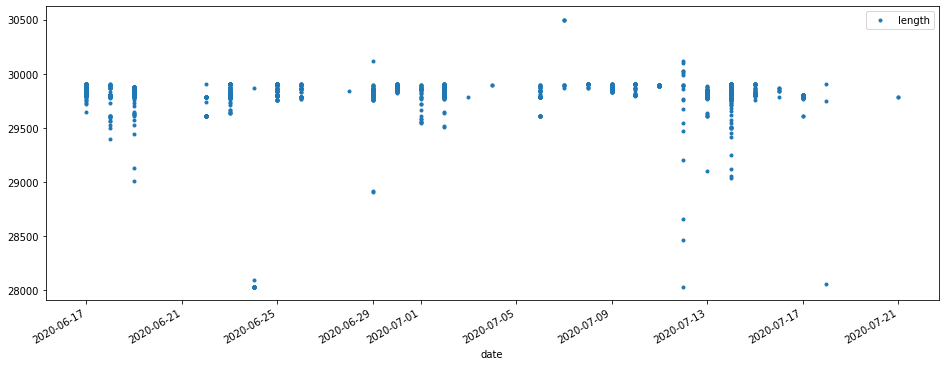

In [40]:
# Genome size over time
corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

In [60]:
# Display original novel coronavirus
corona[corona["collection_date"] == "Dec-2019"].head()

,length,date,information,description,sequence,file_path,genus,subgenus,unknown,country,host,strain,collection_date
id,,,,,,,,,,,,,
NC_045512.2,29903,2020-07-18,1.189343,Severe acute respiratory syndrome coronavirus ...,"(A, T, T, A, A, A, G, G, T, T, T, A, T, A, C, ...",../data/genbank/coronaviridae/NC_045512.2.gb,betacoronavirus,sarbecovirus,0.0,china,homo sapiens,unknown,Dec-2019


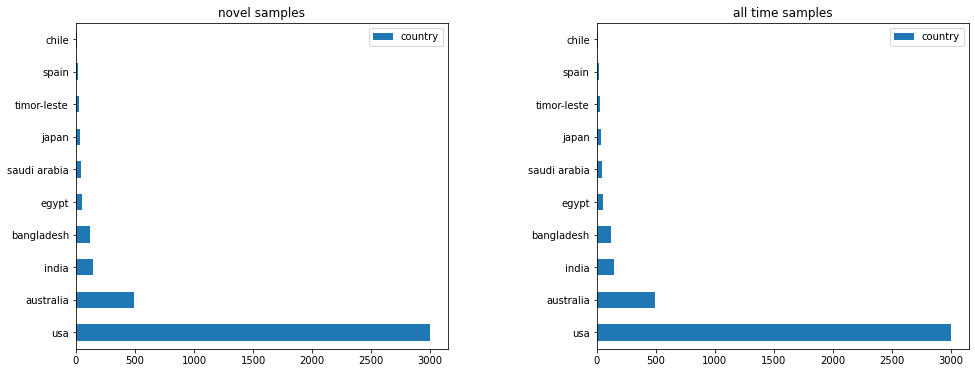

In [64]:
novel_corona = corona
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

countries = pd.DataFrame(novel_corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

countries = pd.DataFrame(corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

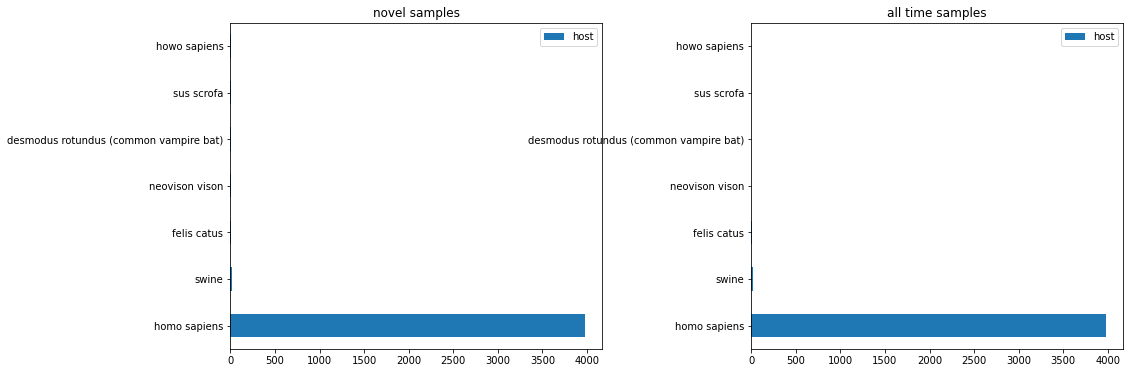

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

hosts = pd.DataFrame(novel_corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

hosts = pd.DataFrame(corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

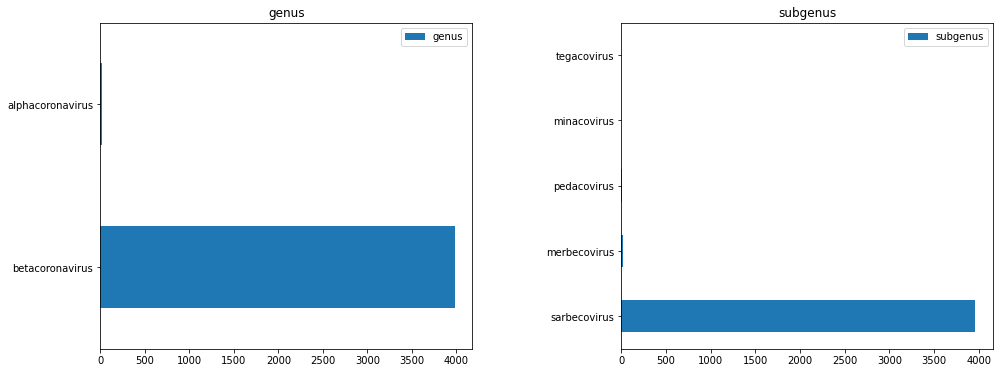

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

genus = pd.DataFrame(corona["genus"].value_counts())
genus = genus[genus.index != "unknown"]
genus.head(10).plot(kind = 'barh', ax=axes[0], title="genus");

subgenus = pd.DataFrame(corona["subgenus"].value_counts())
subgenus = subgenus[subgenus.index != "unknown"]
subgenus.head(10).plot(kind = 'barh', ax=axes[1], title="subgenus");

In [ ]:
# Note: Need to go back and download more as (n=5000) is not enough samples to pick up older sequences!

# 5000 has 128Mb csv file

# Try 20,000